# GPytorch version

In [63]:
# SIMULATED DATA EXPERIMENTS
# # RUN WITH python run_sim_experiments_dfNGPcm.py
# 
#       ooooooooooooooooooooooooooooooooooooo
#      8                                .d88
#      8  oooooooooooooooooooooooooooood8888
#      8  8888888888888888888888888P"   8888    oooooooooooooooo
#      8  8888888888888888888888P"      8888    8              8
#      8  8888888888888888888P"         8888    8             d8
#      8  8888888888888888P"            8888    8            d88
#      8  8888888888888P"               8888    8           d888
#      8  8888888888P"                  8888    8          d8888
#      8  8888888P"                     8888    8         d88888
#      8  8888P"                        8888    8        d888888
#      8  8888oooooooooooooooooooooocgmm8888    8       d8888888
#      8 .od88888888888888888888888888888888    8      d88888888
#      8888888888888888888888888888888888888    8     d888888888
#                                               8    d8888888888
#         ooooooooooooooooooooooooooooooo       8   d88888888888
#        d                       ...oood8b      8  d888888888888
#       d              ...oood888888888888b     8 d8888888888888
#      d     ...oood88888888888888888888888b    8d88888888888888
#     dood8888888888888888888888888888888888b
#
#
# This artwork is a visual reminder that this script is for the sim experiments.

model_name = "dfNGP"
from GPyTorch_models import dfNGP

# import configs to we can access the hypers with getattr
import configs
from configs import PATIENCE, MAX_NUM_EPOCHS, NUM_RUNS, WEIGHT_DECAY
# also import x_test grid size and std noise for training data
from configs import N_SIDE, STD_GAUSSIAN_NOISE
from configs import TRACK_EMISSIONS_BOOL

# Reiterating import for visibility
MAX_NUM_EPOCHS = MAX_NUM_EPOCHS
NUM_RUNS = NUM_RUNS
NUM_RUNS = 1
WEIGHT_DECAY = WEIGHT_DECAY
PATIENCE = PATIENCE

# assign model-specific variable
MODEL_LEARNING_RATE = getattr(configs, f"{model_name}_SIM_LEARNING_RATE")
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")
import os
os.makedirs(MODEL_SIM_RESULTS_DIR, exist_ok = True)

# basics
import pandas as pd
import torch
import gpytorch

# universals 
from metrics import compute_divergence_field
from utils import set_seed, make_grid
import gc
import warnings
set_seed(42)

# setting device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overwrite if needed: # device = 'cpu'
print('Using device:', device)
print()

### START TIMING ###
import time
start_time = time.time()  # Start timing after imports

### START TRACKING EXPERIMENT EMISSIONS ###
if TRACK_EMISSIONS_BOOL:
    from codecarbon import EmissionsTracker
    tracker = EmissionsTracker(project_name = "dfGP_simulation_experiments", output_dir = MODEL_SIM_RESULTS_DIR)
    tracker.start()

### SIMULATION ###
# Import all simulation functions
from simulate import (
    simulate_detailed_branching,
    simulate_detailed_curve,
    simulate_detailed_deflection,
    simulate_detailed_edge,
    simulate_detailed_ridges,
)

# Define simulations as a dictionary with names as keys to function objects
# alphabectic order here
simulations = {
    "curve": simulate_detailed_curve,
}

########################
### x_train & x_test ###
########################

# Load training inputs (once for all simulations)
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

# Generate x_test (long) once for all simulations
_, x_test = make_grid(N_SIDE)
# x_test is long format (N_SIDE ** 2, 2)

#################################
### LOOP 1 - over SIMULATIONS ###
#################################

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    ########################
    ### y_train & y_test ###
    ########################

    # Generate training observations
    # NOTE: sim_func() needs to be on CPU, so we move x_train to CPU
    y_train = sim_func(x_train.cpu()).to(device)
    y_test = sim_func(x_test.cpu()).to(device)
    
    x_test = x_test.to(device)
    x_train = x_train.to(device)

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Training inputs shape: {x_train.shape}")
    print(f"Training observations shape: {y_train.shape}")
    print(f"Training inputs dtype: {x_train.dtype}")
    print(f"Training inputs device: {y_train.device}")
    print(f"Training observations device: {y_train.device}")
    print()

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Test inputs shape: {x_test.shape}")
    print(f"Test observations shape: {y_test.shape}")
    print(f"Test inputs dtype: {x_test.dtype}")
    print(f"Test inputs device: {x_test.device}")
    print(f"Test observations device: {y_test.device}")
    print()

    # NOTE: This is different to the real data experiments
    # calculate the mean magnitude of the test data as we use this to scale the noise
    sim_mean_magnitude_for_noise = torch.norm(y_test, dim = -1).mean().to(device)
    sim_noise = STD_GAUSSIAN_NOISE * sim_mean_magnitude_for_noise

    # Store metrics for the simulation (used for *metrics_summary* report and *metrics_per_run*)
    simulation_results = [] 

    ##################################
    ### LOOP 2 - over training run ###
    ##################################

    # NOTE: GPs don't train on batches, use full data

    for run in range(NUM_RUNS):

        print(f"\n--- Training Run {run + 1}/{NUM_RUNS} ---")

        # Additive noise model: independent Gaussian noise
        # For every run we have a FIXED NOISY TARGET. Draw from standard normal with appropriate std
        y_train_noisy = y_train + (torch.randn(y_train.shape, device = device) * sim_noise)

        # Initialise the likelihood for the GP model (estimates noise)
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

        # Intialise fresh GP model with flat x_train and y_train_noisy (block-flat)
        model = dfNGP(
            x_train.T.reshape(-1),
            y_train_noisy.T.reshape(-1), 
            likelihood,
            ).to(device)
        
        optimizer = torch.optim.AdamW([
            {"params": model.mean_module.parameters(), "weight_decay": WEIGHT_DECAY, "lr": (10.0 * MODEL_LEARNING_RATE)},
            {"params": list(model.covar_module.parameters()) + list(model.likelihood.parameters()), "weight_decay": WEIGHT_DECAY, "lr": MODEL_LEARNING_RATE},
            ])
                
        # Use ExactMarginalLogLikelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        model.train()
        likelihood.train()
        
        # _________________
        # BEFORE EPOCH LOOP

        # Export the convergence just for first run only
        if run == 0:
            # initialise tensors to store losses over epochs (for convergence plot)
            train_losses_NLML_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # objective
            train_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # by-product
            # monitor performance transfer to test (only RMSE easy to calc without covar)
            test_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

            sigma_n_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            sigma_f_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l1_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l2_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

        # Early stopping variables
        best_loss = float('inf')
        # counter starts at 0
        epochs_no_improve = 0

        ############################
        ### LOOP 3 - over EPOCHS ###
        ############################

        print("\nStart Training")

        for epoch in range(MAX_NUM_EPOCHS):

            # Set to train
            model.train()
            likelihood.train()

            # Do a step
            optimizer.zero_grad()
            # model outputs a multivariate normal distribution
            train_pred_dist = model(x_train.T.reshape(-1).to(device))
            # Train on noisy or true targets?
            loss = - mll(train_pred_dist, y_train_noisy.T.reshape(-1).to(device))  # negative marginal log likelihood
            loss.backward()
            optimizer.step()

            # For Run 1 we save a bunch of metrics and update, while for the rest we only update
            if run == 0:

                model.eval()
                likelihood.eval()

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", gpytorch.utils.warnings.GPInputWarning)
                    train_pred_dist = model(x_train.T.reshape(-1).to(device))
                test_pred_dist = model(x_test.T.reshape(-1).to(device))

                # Compute RMSE for training and test predictions (given true data, not noisy)
                train_RMSE = torch.sqrt(gpytorch.metrics.mean_squared_error(train_pred_dist, y_train.T.reshape(-1).to(device)))
                test_RMSE = torch.sqrt(gpytorch.metrics.mean_squared_error(test_pred_dist, y_test.T.reshape(-1).to(device)))

                # Save losses for convergence plot
                train_losses_NLML_over_epochs[epoch] = loss.item()
                train_losses_RMSE_over_epochs[epoch] = train_RMSE.item()
                test_losses_RMSE_over_epochs[epoch] = test_RMSE.item()

                # Save evolution of hypers for convergence plot
                sigma_n_over_epochs[epoch] = model.likelihood.noise.item()
                sigma_f_over_epochs[epoch] = model.covar_module.outputscale.item()
                l1_over_epochs[epoch] = model.covar_module.lengthscale[0].item()
                l2_over_epochs[epoch] = model.covar_module.lengthscale[1].item()

                # Print a bit more information for the first run
                if epoch % 20 == 0:
                    print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}, (RMSE): {train_RMSE:.4f}")

                # delete after printing and saving
                # NOTE: keep loss for early stopping check
                # del train_pred_dist, test_pred_dist, train_RMSE, test_RMSE
                
                # Free up memory every 20 epochs
                if epoch % 20 == 0:
                    gc.collect() and torch.cuda.empty_cache()
            
            # For all runs after the first we run a minimal version using only lml_train
            else:
                if epoch % 20 == 0:
                    # After run 1 we only print lml, nothing else
                    print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}")
                
            # EVERY EPOCH: Early stopping check
            if loss < best_loss:
                best_loss = loss
                # reset counter if loss improves
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                # exit epoch loop
                break

Using device: cuda

=== CURVE ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32
Training inputs device: cuda:0
Training observations device: cuda:0

=== CURVE ===
Test inputs shape: torch.Size([400, 2])
Test observations shape: torch.Size([400, 2])
Test inputs dtype: torch.float32
Test inputs device: cuda:0
Test observations device: cuda:0


--- Training Run 1/1 ---

Start Training
curve dfNGP Run 1/1, Epoch 1/2000, Training Loss (NLML): -0.1364, (RMSE): 0.7692
curve dfNGP Run 1/1, Epoch 21/2000, Training Loss (NLML): -0.1430, (RMSE): 0.0999
curve dfNGP Run 1/1, Epoch 41/2000, Training Loss (NLML): -0.1833, (RMSE): 0.0791
curve dfNGP Run 1/1, Epoch 61/2000, Training Loss (NLML): -0.2366, (RMSE): 0.0708
curve dfNGP Run 1/1, Epoch 81/2000, Training Loss (NLML): -0.2961, (RMSE): 0.0646
curve dfNGP Run 1/1, Epoch 101/2000, Training Loss (NLML): -0.3590, (RMSE): 0.0600
curve dfNGP Run 1/1, Epoch 121/2000, T

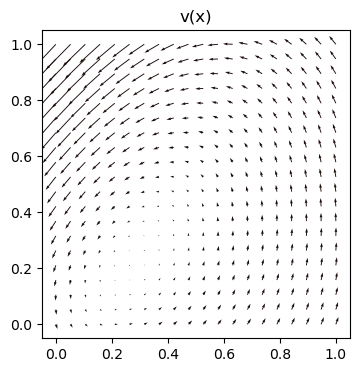

In [ ]:
x = x_test.T.reshape(-1).reshape(2, -1).T
mean_x_from_dfNN = model.mean_module(x_for_dfNN)
visualise_v_quiver(mean_x_from_dfNN, x_for_dfNN)

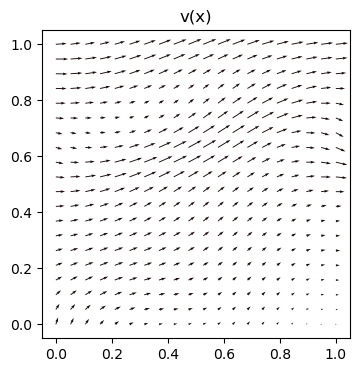

In [67]:
pred = model(x)
model_out = pred.mean.reshape(2, -1).T

visualise_v_quiver(model_out, x_for_dfNN)